# EcoVision — мониторинг экосистемы по данным фотоловушек

## 1. Постановка задачи

Цель проекта — разработать прототип IT-системы для автоматического анализа изображений с фотоловушек с использованием предобученной модели машинного обучения.

Задачи:
- Детекция объектов на изображениях
- Агрегация результатов в таблицу
- Анализ распределения классов и confidence
- Формирование алертов о потенциально критических событиях

## Используемая модель

В проекте используется YOLOv8 (ultralytics) — предобученная модель object detection.
Обучение не проводилось, используется inference.

## 2. Подготовка данных

На вход подаются изображения с фотоловушек (ночные ИК-кадры и дневные сцены).
Изображения загружаются в архиве и распаковываются в рабочую директорию.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving wildlife.zip to wildlife (1).zip


In [72]:
import zipfile
from pathlib import Path

DATA_DIR = Path("/content/data/images")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# берём имя загруженного zip автоматически
zip_name = [k for k in uploaded.keys() if k.lower().endswith(".zip")][0]
zip_path = Path("/content") / zip_name

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(DATA_DIR)

print("ZIP:", zip_name)
print("Images found:", len(list(DATA_DIR.glob("*"))))

ZIP: wildlife (1).zip
Images found: 20


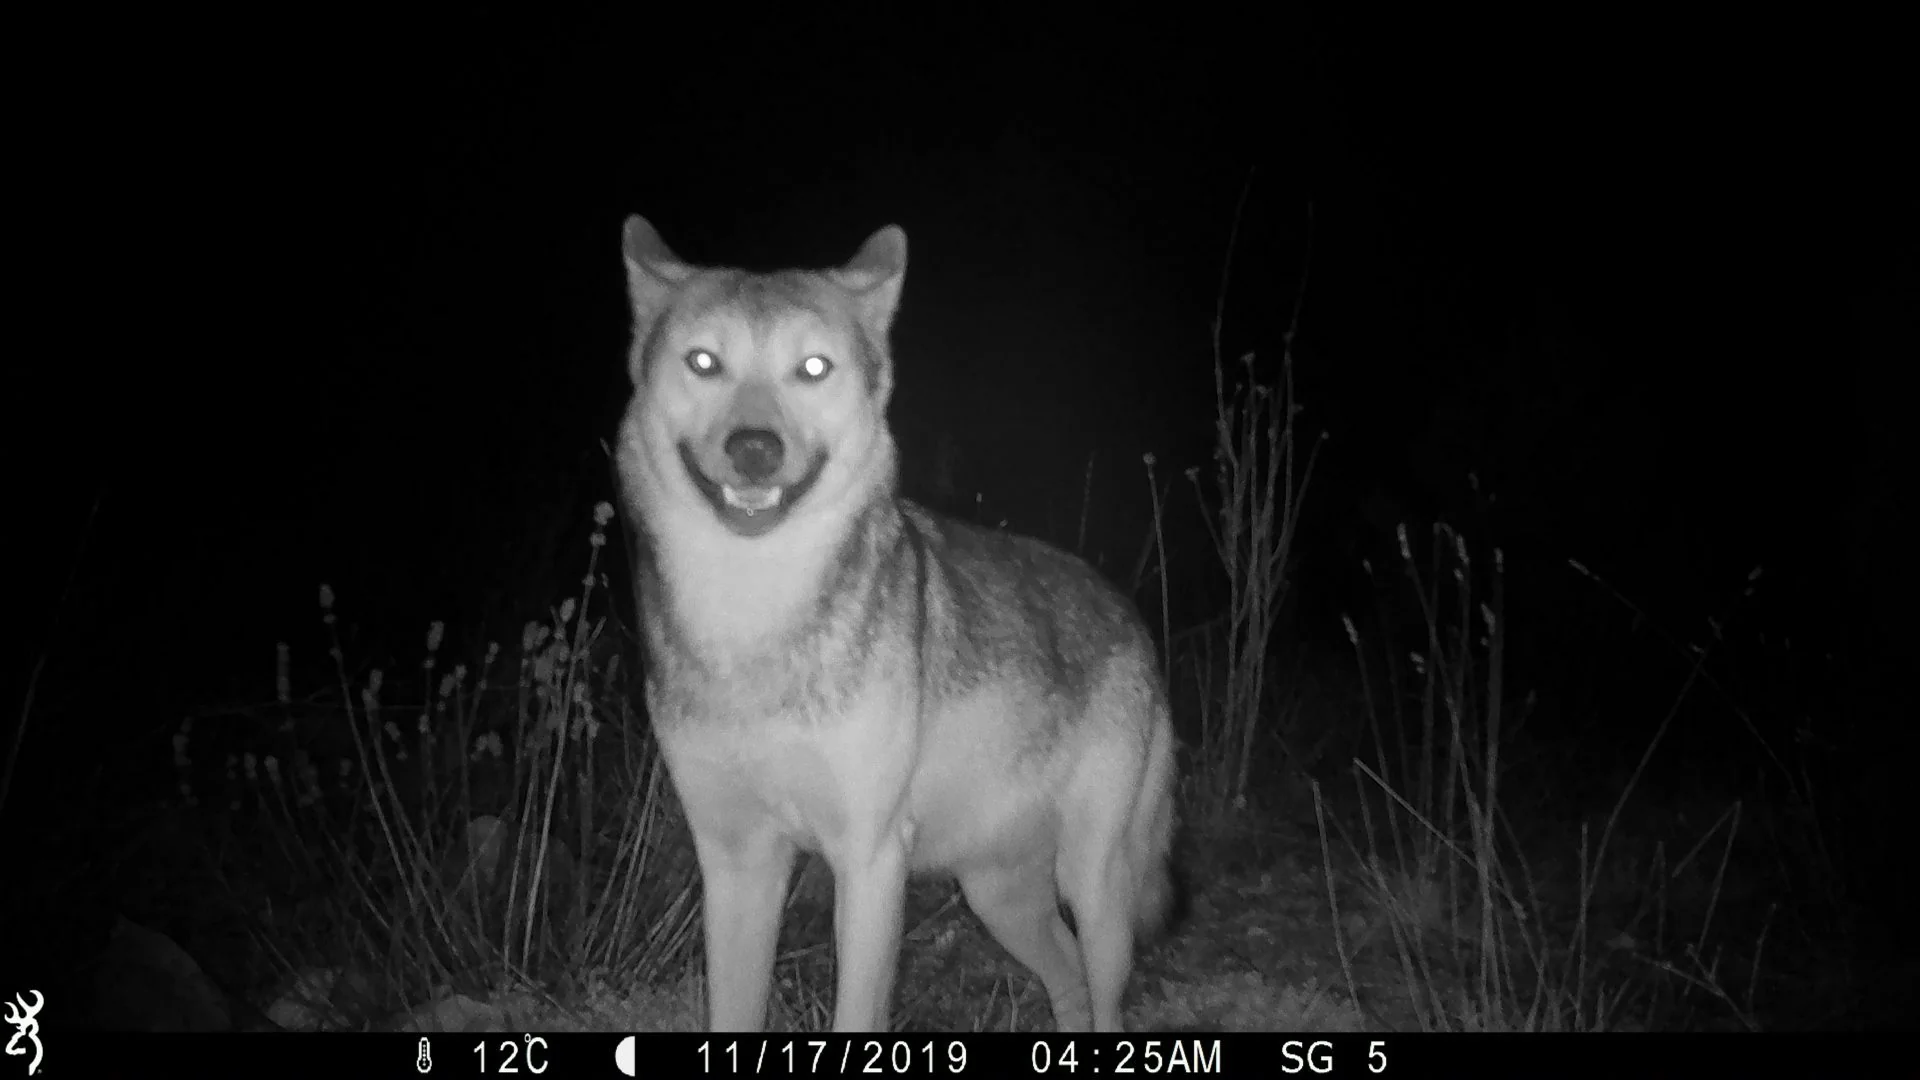

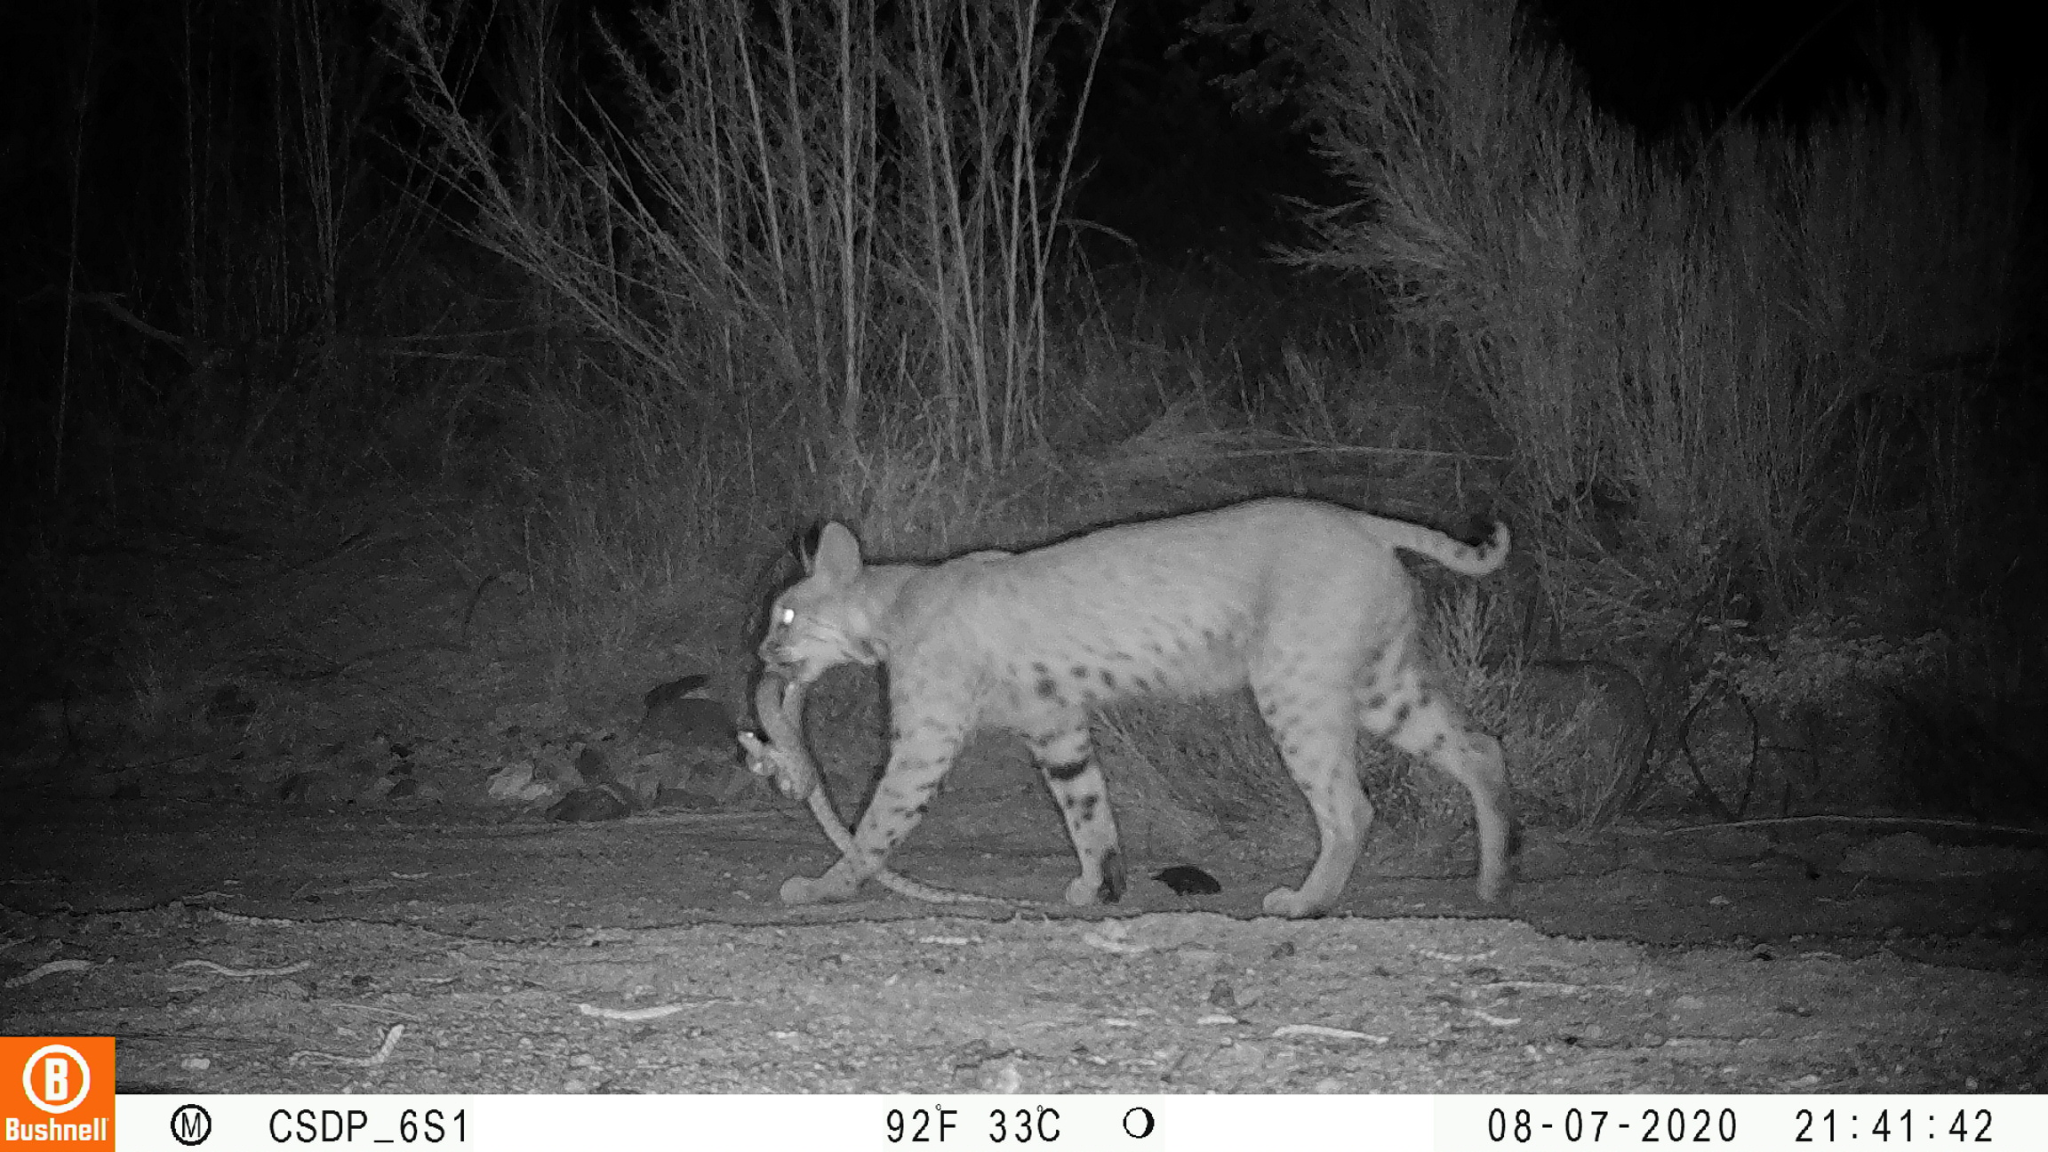

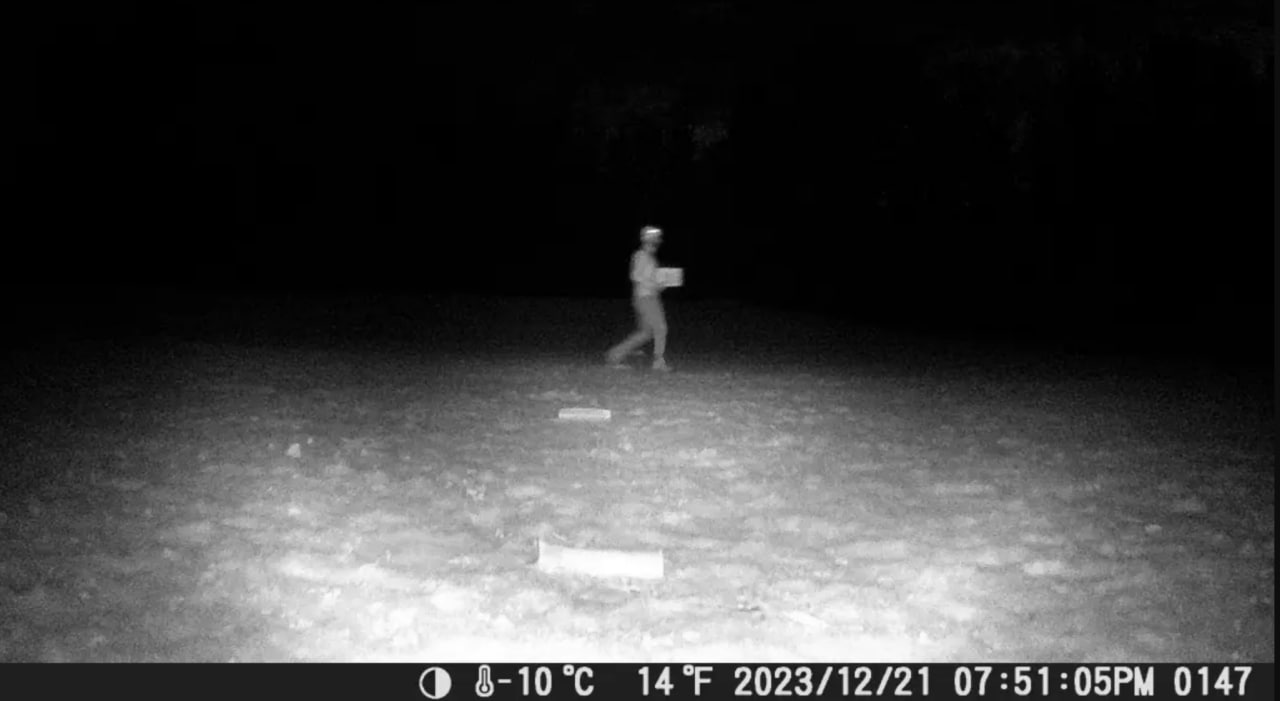

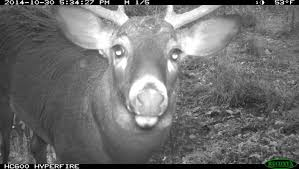

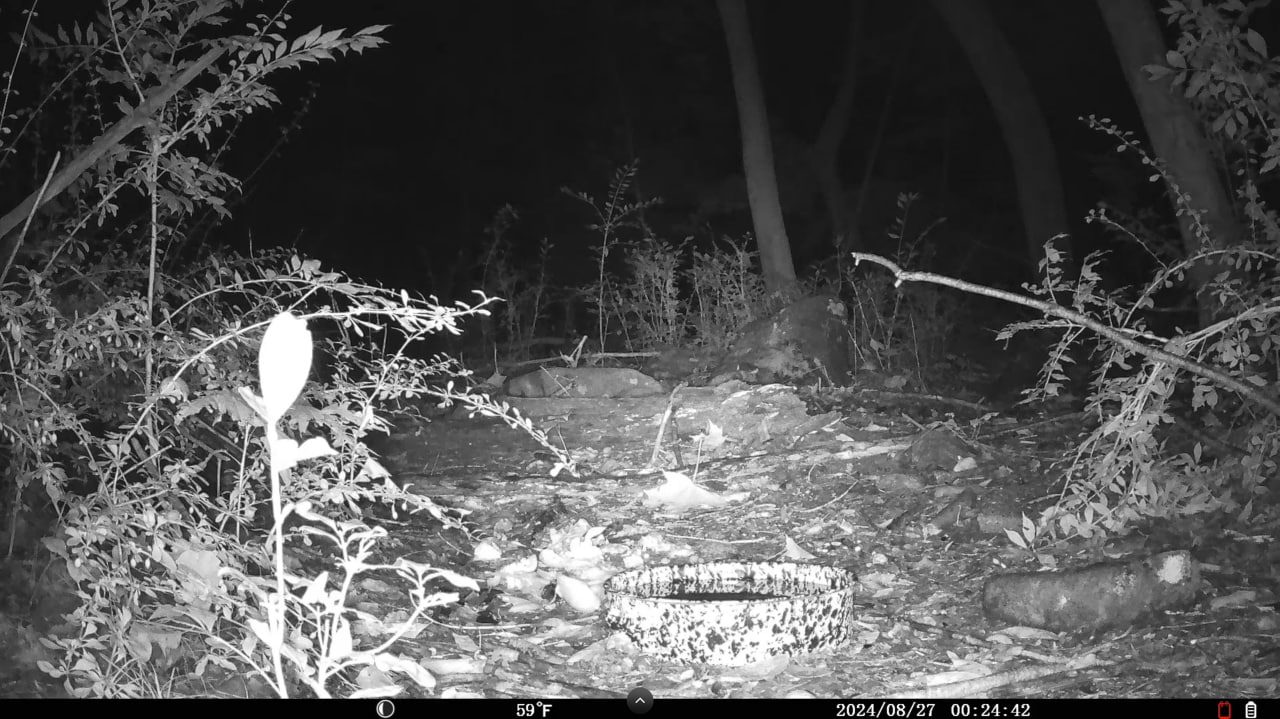

In [73]:
from IPython.display import Image, display
import random

images = list(DATA_DIR.glob("*"))
for img in random.sample(images, min(5, len(images))):
    display(Image(filename=str(img)))

In [74]:
!pip -q install -U ultralytics

In [75]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import cv2
from tqdm import tqdm

OUT_DIR = Path("/content/outputs")
ANN_DIR = OUT_DIR / "annotated_images"
OUT_DIR.mkdir(parents=True, exist_ok=True)
ANN_DIR.mkdir(parents=True, exist_ok=True)

# Загружаем предобученную модель YOLOv8
model = YOLO("yolov8n.pt")

# Получаем список изображений для обработки
image_paths = sorted([p for p in DATA_DIR.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png",".webp"]])
print("Images:", len(image_paths))

records = []

# Проходим по каждому изображению и выполняем детекцию
for img_path in tqdm(image_paths):

    # Запуск модели (inference)
    results = model.predict(source=str(img_path), conf=0.20, imgsz=960, iou=0.6, verbose=False)
    r = results[0]

    # сохраняем картинку с рамками
    annotated = r.plot()
    cv2.imwrite(str(ANN_DIR / img_path.name), annotated)

    # собираем детекции в таблицу
    # Если объектов нет — фиксируем пустой кадр
    if r.boxes is None or len(r.boxes) == 0:
        records.append({"filename": img_path.name, "class": None, "confidence": None})
        continue

    names = r.names

    # Сохраняем информацию о найденных объектах
    for b in r.boxes:
        records.append({
            "filename": img_path.name,
            "class": names[int(b.cls.item())],
            "confidence": float(b.conf.item())
        })

df = pd.DataFrame(records)
df.head()

Images: 20


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


filename   class  confidence
0   img1.png     dog    0.452887
1   img1.png     cow    0.321864
2  img10.jpg     cow    0.476308
3  img11.jpg     dog    0.249220
4  img12.jpg  person    0.813387

## 3. Количественная оценка результатов

Так как модель не дообучается и отсутствует разметка,
качество оценивается количественно:
- общее число обработанных изображений
- доля пустых кадров
- количество детекций
- средняя и медианная уверенность (confidence)

In [76]:
total_images = df["filename"].nunique()
empty_images = df[df["class"].isna()]["filename"].nunique()
conf_df = df.dropna(subset=["confidence"])

quality_report = {
    "total_images": total_images,
    "empty_images": empty_images,
    "empty_share": round(empty_images/total_images, 3),
    "detections_total": int(conf_df.shape[0]),
    "confidence_mean": float(round(conf_df["confidence"].mean(), 3)) if len(conf_df) else None,
    "confidence_median": float(round(conf_df["confidence"].median(), 3)) if len(conf_df) else None,
}
quality_report

{'total_images': 20,
 'empty_images': 6,
 'empty_share': 0.3,
 'detections_total': 19,
 'confidence_mean': 0.485,
 'confidence_median': 0.453}

# Анализ результатов

Обработано 20 изображений.
Доля пустых кадров составляет 30%, что может указывать на:
- низкую активность животных
- некорректное расположение камеры

Средняя уверенность модели ≈ 0.48, что является приемлемым результатом для ночных ИК-снимков.

Обнаружен человек в кадре — это потенциально критическое событие для охраняемой территории.

In [77]:
import shutil
from google.colab import files

shutil.make_archive("/content/outputs/annotated_images", "zip", "/content/outputs/annotated_images")
files.download("/content/outputs/annotated_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
allowed = {"person", "dog", "cat", "horse", "sheep", "cow", "bird", "bear", "deer"}
df_clean = df[df["class"].isin(allowed) | df["class"].isna()].copy()

# дальше графики строй по df_clean

## 4. Анализ распределения детекций

Проводится анализ:
- частоты классов
- распределения confidence

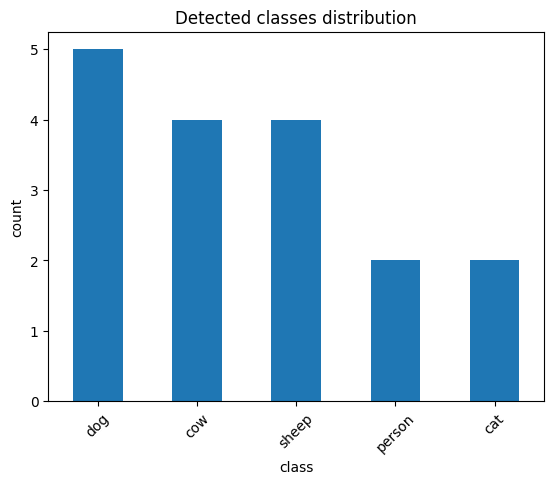

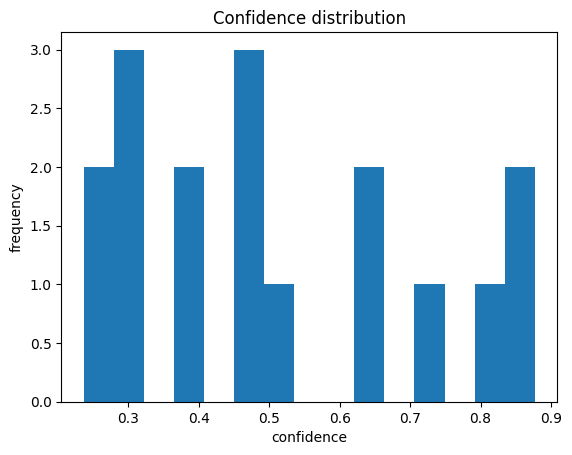

In [79]:
import matplotlib.pyplot as plt

conf_df = df_clean.dropna(subset=["class","confidence"])

# 1. Распределение классов
plt.figure()
conf_df["class"].value_counts().plot(kind="bar")
plt.title("Detected classes distribution")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.show()

# 2. Confidence histogram
plt.figure()
plt.hist(conf_df["confidence"], bins=15)
plt.title("Confidence distribution")
plt.xlabel("confidence")
plt.ylabel("frequency")
plt.show()

## 5. Формирование алертов

Реализованы события мониторинга:
- CRITICAL — обнаружение человека (высокая уверенность)
- INFO — обнаружение человека с низкой уверенностью
- WARNING — высокая доля пустых кадров

In [80]:
def build_alerts(df, person_conf_threshold=0.6, empty_share_threshold=0.25):
    alerts = []

    # CRITICAL: person (только уверенные детекции)
    person_strong = df[(df["class"] == "person") & (df["confidence"] >= person_conf_threshold)]["filename"].unique()
    if len(person_strong) > 0:
        alerts.append(("CRITICAL", f"High-confidence person detected on {len(person_strong)} image(s)."))

    # INFO: слабые детекции person (не тревога, а на проверку)
    person_weak = df[(df["class"] == "person") & (df["confidence"] < person_conf_threshold)]["filename"].unique()
    if len(person_weak) > 0:
        alerts.append(("INFO", f"Low-confidence person detections on {len(person_weak)} image(s) — manual review recommended."))

    # WARNING: высокая доля пустых кадров
    total = df["filename"].nunique()
    empty = df[df["class"].isna()]["filename"].nunique()
    empty_share = empty / total if total else 0
    if empty_share > empty_share_threshold:
        alerts.append(("WARNING", f"High empty frame ratio: {empty_share:.0%} (> {empty_share_threshold:.0%})."))

    return alerts

alerts = build_alerts(df)

for level, msg in alerts:
    print(f"[{level}] {msg}")

[CRITICAL] High-confidence person detected on 2 image(s).
[WARNING] High empty frame ratio: 30% (> 25%).


# Результаты

В ходе работы был реализован прототип системы мониторинга экосистемы на основе изображений фотоловушек.

Результаты обработки:

обработано 20 изображений

30% кадров пустые

выполнено 19 детекций объектов

средняя уверенность модели ≈ 0.48

Обнаружены события:

CRITICAL: обнаружение человека (возможное нарушение охраняемой территории)

WARNING: высокая доля пустых кадров (возможное снижение активности или проблема установки камеры)

Ограничения:

используется модель общего назначения (COCO)

возможны неточности в видовой классификации (например, волк определяется как dog)

In [81]:
from pathlib import Path

OUT_DIR = Path("/content/outputs")
OUT_DIR.mkdir(exist_ok=True)

df.to_csv(OUT_DIR / "detections.csv", index=False)

print("Saved to:", OUT_DIR / "detections.csv")

Saved to: /content/outputs/detections.csv


In [82]:
from google.colab import files
files.download("/content/outputs/detections.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. Выводы

Прототип демонстрирует возможность автоматизации первичной обработки изображений фотоловушек.

Система:
- выполняет детекцию объектов
- агрегирует результаты
- визуализирует статистику
- выявляет потенциально критические события

Ограничения:
- используется модель общего назначения (COCO)
- возможны ложные срабатывания на ночных ИК-кадрах
- видовая классификация приблизительная

Перспективы улучшения:
- использование специализированной wildlife-модели
- дообучение на релевантных данных
- внедрение потоковой обработки